<a href="https://colab.research.google.com/github/AlejandrodelaConcha/Deep-Learning/blob/master/HWK1/Alejandro_de_la_Concha_TD1_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <h1>
Image Classification and Regression
    </h1>
</center>

These lines of code generate the datasets for the experiments. Three different figures are generated: triangles, rectangles and circles. 

In [0]:


import sys
import os

path=os.path.dirname(os.getcwd())
sys.path.append(path)
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
from keras.utils import np_utils
import copy
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_rectangles(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V,noise),generate_a_drawing(figsize, U, V,0)]


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_disks(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V,noise),generate_a_drawing(figsize, U, V,0)]

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2.
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_triangles(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata= generate_a_drawing(figsize, U, V, 0)
    imdata_noisy= generate_a_drawing(figsize, U, V, noise)
    return [imdata_noisy,imdata,  [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False,verbose=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if(verbose):
                print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification(free_location=False,verbose=True):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location,verbose)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0,free_location=True,verbose=True):
    # Getting im_size:
    
    im_size = generate_a_triangle()[0].shape[0]
    
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if verbose:
                print(i)
        flag=True
        while(flag):
          [X[i], Y[i]] = generate_a_triangle(noise, free_location)
          a=np.sqrt((X[i][2]-X[i][0])**2+(X[i][3]-X[i][1])**2)
          b=np.sqrt((X[i][4]-X[i][2])**2+(X[i][5]-X[i][3])**2)     
          area=(a*b)/2.
          if area>0.005:
            flag=False
          else:
            flag=True
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    

def generate_test_set_regression(free_location=True,verbose=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20,free_location,verbose=False)
    return [X_test, Y_test]


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False,verbose=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            if verbose:
                print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],Y[i]] = generate_rectangles(noise, free_location)
        elif category == 1: 
            [X[i],Y[i]]= generate_disks(noise, free_location)
        else:
            [X[i],Y[i], V] = generate_triangles(noise, free_location)
    
    X = (X  + noise)/ (255 + 2 * noise)    
    Y = (Y) / (255)
    return [X, Y]

def generate_test_set_denoising(verbose=True):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20,True,verbose)
    return [X_test, Y_test]

def compute_angles(Y):
    Y=Y+1
    first_vector_1=Y[[2,3]]-Y[[0,1]]
    second_vector_1=Y[[4,5]]-Y[[0,1]]
    cos_1= first_vector_1.dot(second_vector_1)/(np.sqrt(np.dot(first_vector_1,first_vector_1))*np.sqrt(np.dot(second_vector_1,second_vector_1)))
    theta_1=np.arccos(cos_1)

    first_vector_2=Y[[0,1]]-Y[[2,3]]
    second_vector_2=Y[[4,5]]-Y[[2,3]]
    cos_2= first_vector_2.dot(second_vector_2)/(np.sqrt(np.dot(first_vector_2,first_vector_2))*np.sqrt(np.dot(second_vector_2,second_vector_2)))
    theta_2=np.arccos(cos_2)

    first_vector_3=Y[[0,1]]-Y[[4,5]]
    second_vector_3=Y[[2,3]]-Y[[4,5]]
    cos_3= first_vector_3.dot(second_vector_3)/(np.sqrt(np.dot(first_vector_3,first_vector_3))*np.sqrt(np.dot(second_vector_3,second_vector_3)))
    theta_3=np.arccos(cos_3)

    return(np.array([theta_1,theta_2,theta_3]))
    
def order_by_angles(Y):
    Y_ordered=copy.deepcopy(Y)
    if(len(Y.shape)>1):
        for i in range(Y.shape[0]):
            thetas=compute_angles(Y[i])
            first_point=np.argsort(thetas)
            Y_ordered[i][[0,2,4]]=Y[i][[0,2,4]][first_point]
            Y_ordered[i][[1,3,5]]=Y[i][[1,3,5]][first_point]
    else:
        thetas=compute_angles(Y)
        first_point=np.argsort(thetas)
        Y_ordered[[0,2,4]]=Y[[0,2,4]][first_point]
        Y_ordered[[1,3,5]]=Y[[1,3,5]][first_point]
    return(Y_ordered)
    


from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Dropout,Input,Flatten,Conv2D, MaxPooling2D,UpSampling2D,merge,concatenate,BatchNormalization
from keras.utils import np_utils
from keras import optimizers,layers,regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Question 1 Simple Classification

You can generate a training set of images of simple geometric shapes (rectangle, disk, triangle) centered in the images by calling the function:

[X_train, Y_train] = generate_dataset_classification(300, 20)

Build and train a linear classifier in Keras to classify a image into one of the three possible categories (i.e. rectangle, disk, triangle). Try using the stochastic gradient descent optimizer, then the Adam optimizer.

Hints: You will have to use the following functions: Sequential, add, Dense (do not forget the
activation), compile, fit, np_utils.to_categorical. For the Adam optimizer, I used a batch size
of 32. You should use a small number of epochs when debugging to see if the optimization seems to
converge correctly.

You can check your classifier using the following code (for example):

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)


I start by generating a dataset with 300 observations.

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20,verbose=False) ### I add verbose to not see the number of points
Y_train=np_utils.to_categorical(Y_train)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1])

Creating data:


As the first task is classification, the problem suggests to create a linear classifier that will be equivalent to just have a layer representing the three classes with softmax as activation function. The loss function used in the problem was cross entropy. 

I trained 3 different models with different optimizers. The goal is to compare ADAM vs the Stochastic Gradient Descent (SGD) as indicated in the HW. The three models were trained by using 100 epochs. For the ADAM model I used a batch size of 32, for the SG a learning rate of 0.1 and 0.001. Aditionally, I analyzed the modified SGD with a momentum of 0.9. 

In [0]:
################# ADAM

model_ADAM=Sequential()
model_ADAM.add(Dense(3,activation="softmax",input_shape=(X_train.shape[1],)))
model_ADAM.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
evolution_ADAM=model_ADAM.fit(X_train,Y_train,
          batch_size=32,epochs=100,verbose=0,validation_split=0.1)

################# SGD 1 with lr=0.01

model_SGD_1=Sequential()
model_SGD_1.add(Dense(3,activation="softmax",input_shape=(X_train.shape[1],)))
sgd = optimizers.SGD()
model_SGD_1.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])
evolution_SGD_1=model_SGD_1.fit(X_train,Y_train,epochs=100,verbose=0,validation_split=0.1)

################# SGD with lr=0.001

model_SGD_2=Sequential()
model_SGD_2.add(Dense(3,activation="softmax",input_shape=(X_train.shape[1],)))
sgd = optimizers.SGD(lr=0.001)
model_SGD_2.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])
evolution_SGD_2=model_SGD_2.fit(X_train,Y_train,epochs=100,verbose=0,validation_split=0.1)

################# SGD 3 with lr=0.001 and momentum=0.9

model_SGD_3=Sequential()
model_SGD_3.add(Dense(3,activation="softmax",input_shape=(X_train.shape[1],)))
sgd = optimizers.SGD(lr=0.001,momentum=0.9)
model_SGD_3.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=["accuracy"])
evolution_SGD_3=model_SGD_3.fit(X_train,Y_train,epochs=100,verbose=0,validation_split=0.1)

W0805 03:27:22.582395 140282762729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 03:27:22.624701 140282762729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 03:27:22.631704 140282762729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 03:27:22.650103 140282762729344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 03:27:22.676877 140282762729344 deprecation_wrappe

I generate the test set to compare the models. 

In [0]:
[X_test, Y_test]=generate_test_set_classification(verbose=False)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1])

Creating data:


We can see in the figure bellow how the ADAM optimizer converged faster compared with the SGD without momentum. In fact, in practice, the ADAM optimizer is commonly preferred.
Additionally, we can see the sensitivity of the SGD to the learning rate. A bad value of the learning rate can lead to poor results as the orange and brown lines indicate.
In this example, we can see how adding the momentum parameter can improve a lot the performance of the SGD optimizer by allowing it to scape from saddle points. 
As we saw in the lectures, in general, the choice of the optimizer depends more on our knowledge of how to modify the parameters.
Another interesthing feature is that it seems that there is not overfitting in the trainned models. 

Text(0.5, 1.0, 'Accuracy')

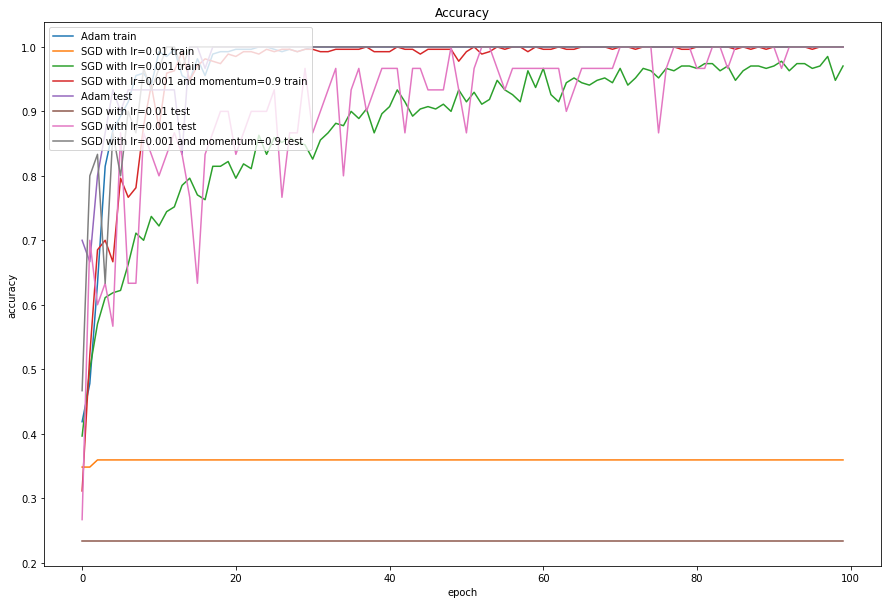

In [0]:
plt.figure(figsize=(15,10))
plt.plot(evolution_ADAM.history['acc'])
plt.plot(evolution_SGD_1.history['acc'])
plt.plot(evolution_SGD_2.history['acc'])
plt.plot(evolution_SGD_3.history['acc'])
plt.plot(evolution_ADAM.history['val_acc'])
plt.plot(evolution_SGD_1.history['val_acc'])
plt.plot(evolution_SGD_2.history['val_acc'])
plt.plot(evolution_SGD_3.history['val_acc'])
plt.legend(['Adam train', 'SGD with lr=0.01 train',"SGD with lr=0.001 train","SGD with lr=0.001 and momentum=0.9 train",'Adam test', 'SGD with lr=0.01 test',"SGD with lr=0.001 test","SGD with lr=0.001 and momentum=0.9 test"], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss function')

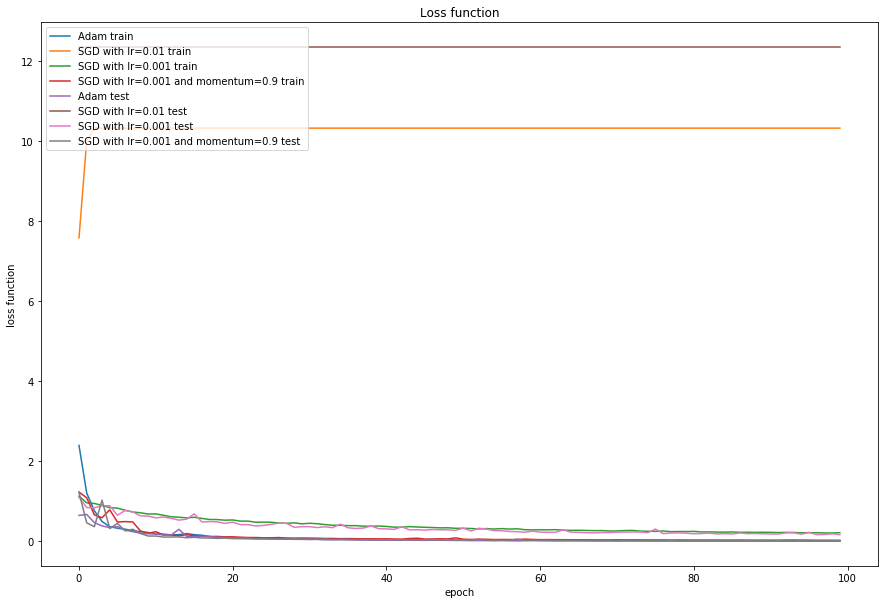

In [0]:
plt.figure(figsize=(15,10))
plt.plot(evolution_ADAM.history['loss'])
plt.plot(evolution_SGD_1.history['loss'])
plt.plot(evolution_SGD_2.history['loss'])
plt.plot(evolution_SGD_3.history['loss'])
plt.plot(evolution_ADAM.history['val_loss'])
plt.plot(evolution_SGD_1.history['val_loss'])
plt.plot(evolution_SGD_2.history['val_loss'])
plt.plot(evolution_SGD_3.history['val_loss'])
plt.legend(['Adam train', 'SGD with lr=0.01 train',"SGD with lr=0.001 train","SGD with lr=0.001 and momentum=0.9 train",'Adam test', 'SGD with lr=0.01 test',"SGD with lr=0.001 test","SGD with lr=0.001 and momentum=0.9 test"], loc='upper left')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.title("Loss function")

When we valuate the models in a test set, I found an accuracy bigger than $95\%$ for the SGD with momentum. The ADAM optimizer gets a smaller value for the loss function an accuracy of $100\%$. In this example, I would choose the ADAM as optmizer.

In [0]:
print("ADAM "+str(model_ADAM.evaluate(X_test,Y_test,verbose=0)))
print('SGD with lr=0.01 '+str(model_SGD_1.evaluate(X_test,Y_test,verbose=0)))
print("SGD with lr=0.001 "+str(model_SGD_2.evaluate(X_test,Y_test,verbose=0)))
print("SGD with lr=0.001 and momentum=0.9 "+str(model_SGD_3.evaluate(X_test,Y_test,verbose=0)))

ADAM [0.009042827195177476, 1.0]
SGD with lr=0.01 [10.530488878885905, 0.346666667064031]
SGD with lr=0.001 [0.21741157909234365, 0.9200000007947285]
SGD with lr=0.001 and momentum=0.9 [0.032271040380001066, 1.0]


# Visualization of the solution

We would like to visualize the weights of the linear classier. Check the output of the function model.get_weights(): The first part corresponds to the matrix of the classifier. Its columns havethe same size as the input images, because Keras uses vector-matrix multiplications instead of matrix-
vector multiplications.

Visualize the 3 columns as images.
Hint: Only two (short) lines of code are required to visualize one column.

The figures below show the weights of the links that go from each pixel to each category. The categories are rectangle, disk and triangle, in that order. I compared the ADAM and the SGD with momentum models. The darker the pixer the bigger the value of the weight of the pixel in the soft-max function of the corresponding category. 

These figures give us an intuition about what features the NN is stracting from the data to classify yhe images.In both models, we can see a rectangle and a triangle detector. For the remainning figures, the results are not clear. It is interesting how, even in a easy task is difficult to interpret what a nn is doing. 

Nevertheless, in both models, the three figures are different showing that the soft-max functions ponderate differently the pixels accordind to the figure they train to predict.

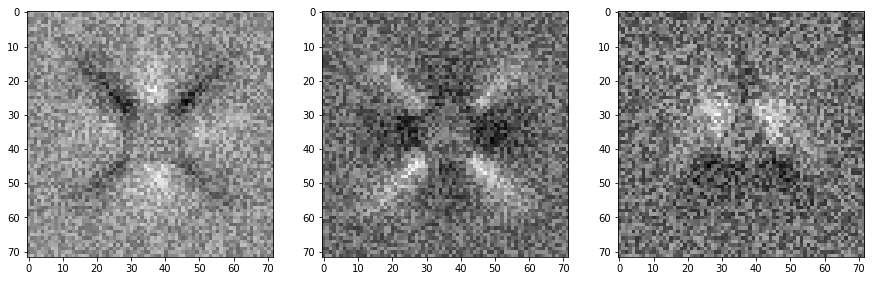

In [0]:
IMAGE_SIZE=72
cl0=model_SGD_3.get_weights()[0][:,0]
cl1=model_SGD_3.get_weights()[0][:,1]
cl2=model_SGD_3.get_weights()[0][:,2]

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(cl0.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(cl1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(cl2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

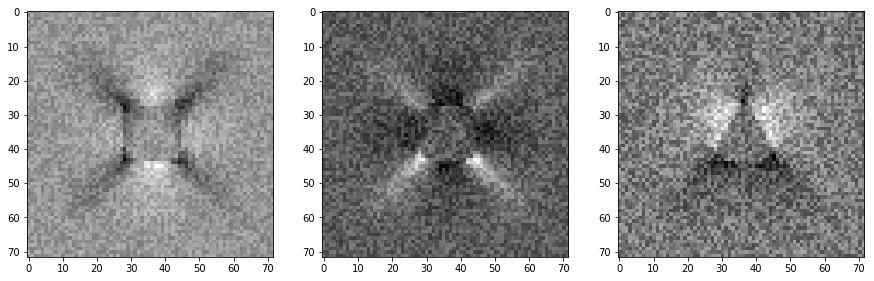

In [0]:
IMAGE_SIZE=72
cl0=model_ADAM.get_weights()[0][:,0]
cl1=model_ADAM.get_weights()[0][:,1]
cl2=model_ADAM.get_weights()[0][:,2]

plt.figure(figsize=(15,10))
plt.subplot(1, 3, 1)
plt.imshow(cl0.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(cl1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(cl2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

# A more difficult classification problem.

In this part, once again, I tried to predict the cluster of each observation, but this time the position and orientation of the figures change. I tried multiple models with relu and softmax as activation functions. In all cases, I used the crossentropy as loss function. I show here the results for the model suggested in the HW without any regulization and another model with regularization and an extra fully connected network.

I generated 1000 samples of the train set as I see that the models had problems to generalize with only 300.

In [0]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True, verbose=False)
X_train=X_train.reshape(X_train.shape[0],72,72,1)
Y_train=np_utils.to_categorical(Y_train)

Creating data:


Suggested model in the HW: 1 convolutional layer with 16 5x5 flters, 1 pooling layer, and one fully connected layer.

In [0]:
model_suggested=Sequential()
model_suggested.add(Conv2D(16,(5,5),activation="relu",input_shape=(72,72,1)))
model_suggested.add(MaxPooling2D(pool_size=(3,3)))
model_suggested.add(Flatten())
model_suggested.add(Dense(3,activation="softmax"))
model_suggested.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
evolution_model_suggested=model_suggested.fit(X_train,Y_train,
          batch_size=32,epochs=100,verbose=0,validation_split=0.1)

Model that improves results (model 2) : Suggested model in the HW: 1 convolutional layer with 16 5x5 flters, 1 pooling layer, and two fully connected layer and with dropout to avoid overfiting . The figures indicate that there is an overfitting in the first model since there is a gap between the train and the validation set, but this problem is resolved  with a Dropout component.

In [0]:
model_2=Sequential()
model_2.add(Conv2D(16,(5,5),activation="relu",input_shape=(72,72,1)))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(Dropout(0.25))
model_2.add(MaxPooling2D(pool_size=(3,3)))
model_2.add(Dropout(0.25))
model_2.add(Flatten())
model_2.add(Dense(128,activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(3,activation="softmax"))
model_2.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
evolution_dropout=model_2.fit(X_train,Y_train,
          batch_size=32,epochs=100,verbose=0,validation_split=0.1)

Text(0.5, 1.0, 'Accuracy')

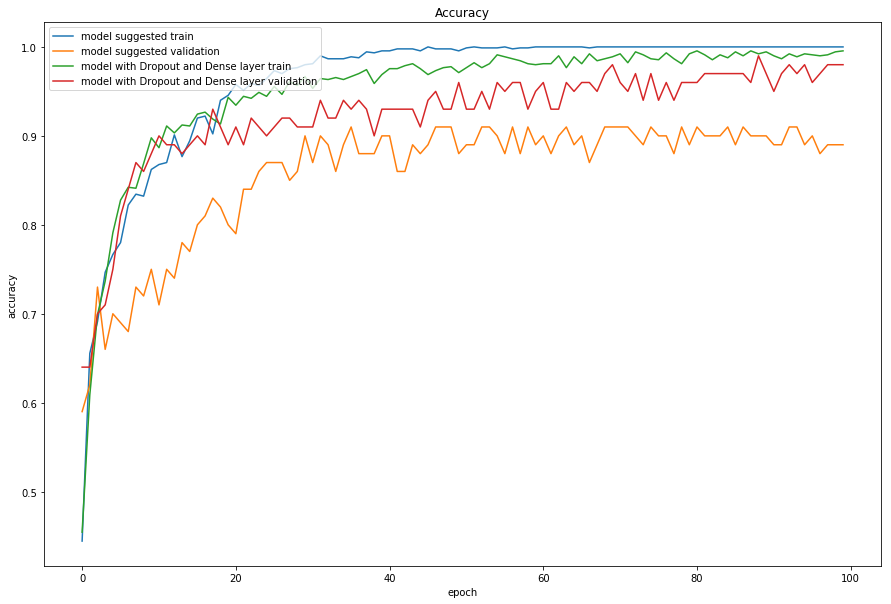

In [0]:
plt.figure(figsize=(15,10))
plt.plot(evolution_model_suggested.history['acc'])
plt.plot(evolution_model_suggested.history['val_acc'])
plt.plot(evolution_dropout.history['acc'])
plt.plot(evolution_dropout.history['val_acc'])
plt.legend(["model suggested train", "model suggested validation","model with Dropout and Dense layer train","model with Dropout and Dense layer validation"], loc="upper left")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss function')

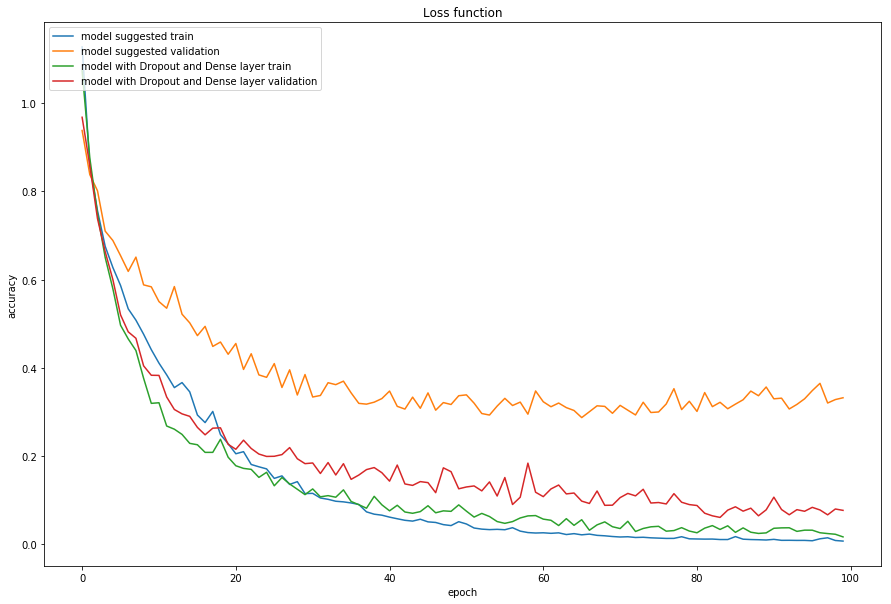

In [0]:
plt.figure(figsize=(15,10))
plt.plot(evolution_model_suggested.history['loss'])
plt.plot(evolution_model_suggested.history['val_loss'])
plt.plot(evolution_dropout.history['loss'])
plt.plot(evolution_dropout.history['val_loss'])
plt.legend(["model suggested train", "model suggested validation","model with Dropout and Dense layer train","model with Dropout and Dense layer validation"], loc="upper left")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Loss function")

I generated a test set to compare both models.

In [0]:
[X_test, Y_test]=generate_test_set_classification(True,verbose=False)
X_test=X_test.reshape(X_test.shape[0],72,72,1)

Creating data:


After training the suggested model, I realized that the difference between the accuracy in the train and test set was big showing overfitting. 
A way to avoid this is to use regularization, for that reason in model 2 I add dropout, that is in the training , the algorithm eliminate some paths with a given probability. I also added a layer. This improved considerable the model as we can see: going from an accuracy of  around $90\%$ to an accuracy of  around $95\%$ in the test set. We can see how the gap between the accuracies in model 2 is smaller showing a smaller degree of overfitting. 

In [0]:
print("Model suggested in train set "+str(model_suggested.evaluate(X_train,Y_train,verbose=2)))
print("Model suggested in test set "+str(model_suggested.evaluate(X_test,Y_test,verbose=2)))
print("Model 2 in train set "+str(model_2.evaluate(X_train,Y_train,verbose=2)))
print("Model 2 in test set "+str(model_2.evaluate(X_test,Y_test,verbose=2)))

Model suggested in train set [0.038321107156574725, 0.989]
Model suggested in test set [0.36187798738479615, 0.9133333325386047]
Model 2 in train set [0.01207005999982357, 0.998]
Model 2 in test set [0.12522500790655614, 0.9600000007947286]


# A regression problem.

The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle. You can generate a training set by calling:

[X_train, Y_train] = generate_dataset_regression(300, 20)

You can visualize a training sample (or a prediction) by calling the visualize_prediction function:

visualize_prediction(X_train[0], Y_train[0])

Build and train a regressor on this data. Evaluate your solution on the test set generated by

[X_test, Y_test] = generate_test_set_regression()

Hint: You may have to normalize somehow the vertices in Y_train and Y_test before training and testing...

In this part, I trained different CNN to detect the vertices of a triangle. As this problem is harder than a classification problem,  I increased the number of samples to 5000. 
I started by doing a normalization of the train set. That is, I reordered the set of vertices according to their x value. 

I also tried to order the vertices according to the angles of the triangle. But I was not satisfied with the results. 

I got the best results by ordering by the x value.


In [0]:
def order_corners(Y):
    Y_ordered=Y_train
    for i in range(Y.shape[0]):
        first_point=np.argsort([Y[i][0],Y[i][2],Y[i][4]])
        Y_ordered[i][[0,2,4]]=Y_train[i][[0,2,4]][first_point]
        Y_ordered[i][[1,3,5]]=Y_train[i][[1,3,5]][first_point]
    return(Y_ordered)

In [75]:
[X_train, Y_train] = generate_dataset_regression(10000, 20,verbose=False)

Creating data:


In [0]:
X_train=X_train.reshape(X_train.shape[0],72,72,1)

In [0]:
Y_train_ordered=order_corners(Y_train)

The first model I analyzed was the suggested one. The results are far away of being optimal. The problem requiere us to learn features that depend on the position and orientation of the triangle and just using a convolutional network is enable to do that.

In [82]:
mcp = ModelCheckpoint('suggested_reg_model.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)
model_suggested_reg=Sequential()
model_suggested_reg.add(Conv2D(16,(5,5),activation="relu",input_shape=(72,72,1)))
model_suggested_reg.add(MaxPooling2D(pool_size=(3,3)))
model_suggested_reg.add(Flatten())
#model_suggested_reg.add(Dense(60))
model_suggested_reg.add(Dense(6))
model_suggested_reg.compile(loss="mean_squared_error",
              optimizer="adam")
model_suggested_reg.fit(X_train,Y_train_ordered,
          batch_size=100,validation_split=0.1,epochs=100,verbose=2,callbacks=[mcp])

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
 - 4s - loss: 0.0528 - val_loss: 0.0262
Epoch 2/100
 - 1s - loss: 0.0249 - val_loss: 0.0214
Epoch 3/100
 - 1s - loss: 0.0214 - val_loss: 0.0196
Epoch 4/100
 - 1s - loss: 0.0196 - val_loss: 0.0188
Epoch 5/100
 - 1s - loss: 0.0186 - val_loss: 0.0177
Epoch 6/100
 - 1s - loss: 0.0176 - val_loss: 0.0174
Epoch 7/100
 - 1s - loss: 0.0169 - val_loss: 0.0169
Epoch 8/100
 - 1s - loss: 0.0164 - val_loss: 0.0163
Epoch 9/100
 - 1s - loss: 0.0156 - val_loss: 0.0170
Epoch 10/100
 - 1s - loss: 0.0153 - val_loss: 0.0154
Epoch 11/100
 - 1s - loss: 0.0143 - val_loss: 0.0148
Epoch 12/100
 - 1s - loss: 0.0141 - val_loss: 0.0145
Epoch 13/100
 - 1s - loss: 0.0136 - val_loss: 0.0141
Epoch 14/100
 - 1s - loss: 0.0133 - val_loss: 0.0142
Epoch 15/100
 - 1s - loss: 0.0129 - val_loss: 0.0140
Epoch 16/100
 - 1s - loss: 0.0125 - val_loss: 0.0137
Epoch 17/100
 - 1s - loss: 0.0123 - val_loss: 0.0143
Epoch 18/100
 - 1s - loss: 0.0120 - val_loss: 0.0134
Epoch 1

In [84]:
[X_test, Y_test] = generate_test_set_regression(verbose=False)
X_test=X_test.reshape(X_test.shape[0],72,72,1)
Y_test_ordered=order_corners(Y_test)

Creating data:


In [0]:
Y_predict_1=model_suggested_reg.predict(X_test)

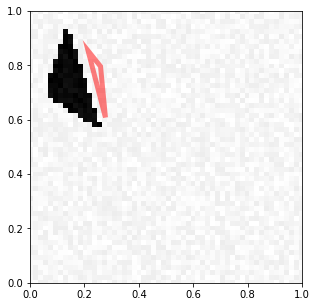

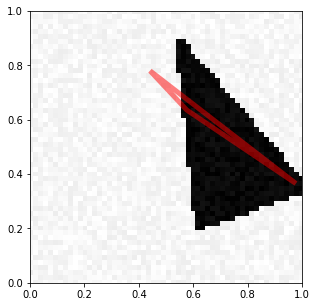

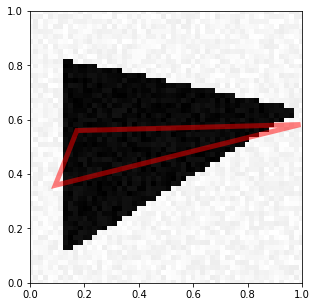

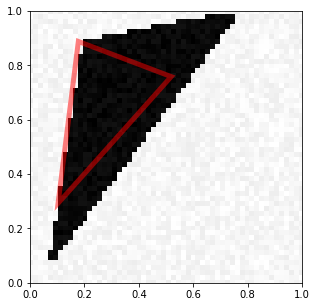

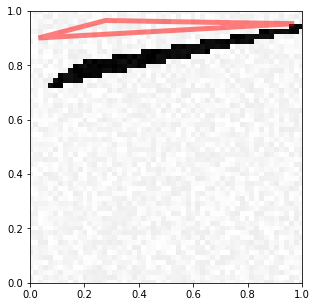

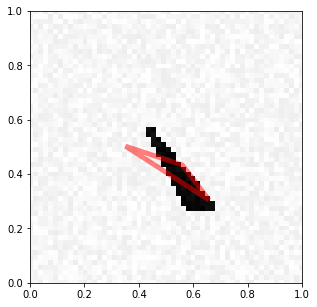

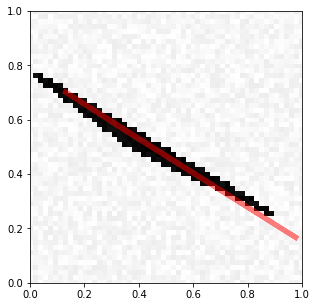

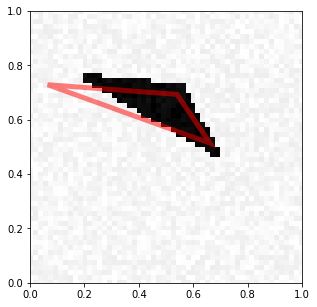

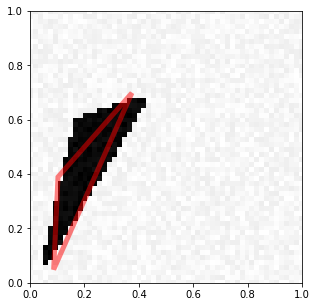

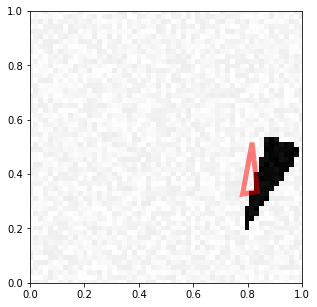

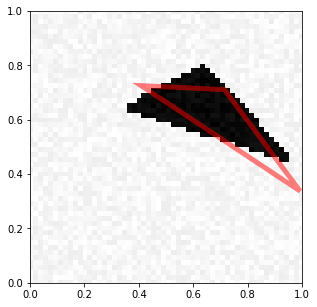

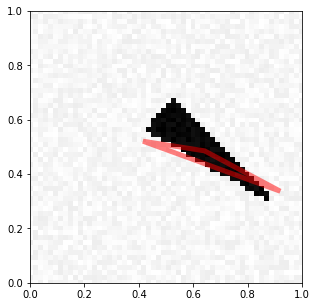

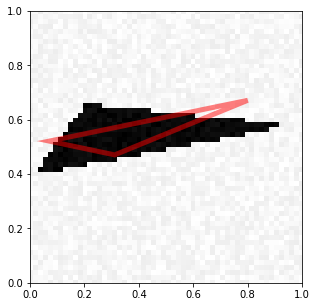

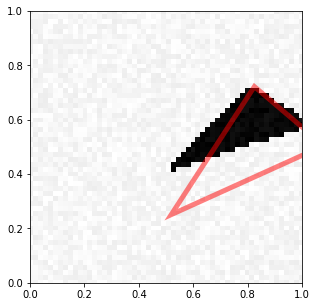

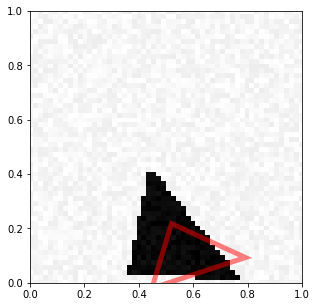

In [86]:
for i in range(40,55):
    visualize_prediction(X_test[i], Y_predict_1[i])  

For the secon model, I tried to improve the performance of the algorithm by increasing the depth of the model. I increased the number of convulutional layers,  dense layers and I added dropout to avoid overfitting. The results are better, but they can be improved. 

In [91]:
model_2_reg=Sequential()
model_2_reg.add(Conv2D(64,(5,5),activation="relu",input_shape=(72,72,1)))
model_2_reg.add(MaxPooling2D(pool_size=(2,2)))
model_2_reg.add(Dropout(0.5))
model_2_reg.add(Conv2D(32,(5,5),activation="relu"))
model_2_reg.add(MaxPooling2D(pool_size=(2,2)))
model_2_reg.add(Dropout(0.25))
model_2_reg.add(Conv2D(16,(5,5),activation="relu"))
model_2_reg.add(MaxPooling2D(pool_size=(2,2)))
model_2_reg.add(Flatten())
model_2_reg.add(Dropout(0.25))
model_2_reg.add(Dense(128,activation="relu"))
model_2_reg.add(Dense(64,activation="relu"))
model_2_reg.add(Dense(32,activation="relu"))
model_2_reg.add(Dense(6))
adam = optimizers.adam(lr=1e-3)
model_2_reg.compile(loss="mean_squared_error",optimizer=adam)
model_2_reg.fit(X_train,Y_train_ordered,
          batch_size=100,validation_split=0.1,epochs=250,verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/250
 - 6s - loss: 0.0692 - val_loss: 0.0885
Epoch 2/250
 - 3s - loss: 0.0362 - val_loss: 0.0546
Epoch 3/250
 - 3s - loss: 0.0277 - val_loss: 0.0509
Epoch 4/250
 - 3s - loss: 0.0230 - val_loss: 0.0387
Epoch 5/250
 - 3s - loss: 0.0187 - val_loss: 0.0276
Epoch 6/250
 - 3s - loss: 0.0158 - val_loss: 0.0213
Epoch 7/250
 - 3s - loss: 0.0139 - val_loss: 0.0189
Epoch 8/250
 - 3s - loss: 0.0124 - val_loss: 0.0143
Epoch 9/250
 - 3s - loss: 0.0115 - val_loss: 0.0134
Epoch 10/250
 - 3s - loss: 0.0108 - val_loss: 0.0111
Epoch 11/250
 - 3s - loss: 0.0100 - val_loss: 0.0090
Epoch 12/250
 - 3s - loss: 0.0094 - val_loss: 0.0076
Epoch 13/250
 - 3s - loss: 0.0088 - val_loss: 0.0064
Epoch 14/250
 - 3s - loss: 0.0086 - val_loss: 0.0063
Epoch 15/250
 - 3s - loss: 0.0081 - val_loss: 0.0063
Epoch 16/250
 - 3s - loss: 0.0079 - val_loss: 0.0058
Epoch 17/250
 - 3s - loss: 0.0077 - val_loss: 0.0055
Epoch 18/250
 - 3s - loss: 0.0074 - val_loss: 0.0065
Epoch 1

In [0]:
Y_predict_2=model_2_reg.predict(X_test)

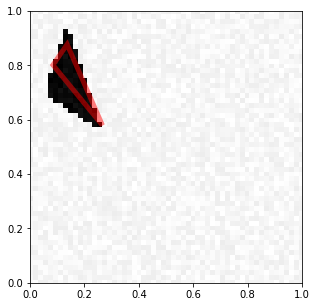

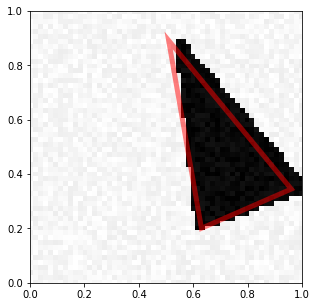

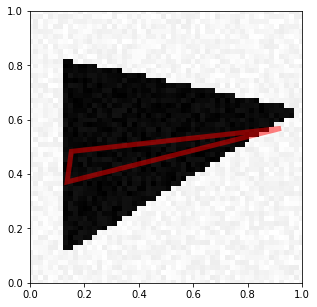

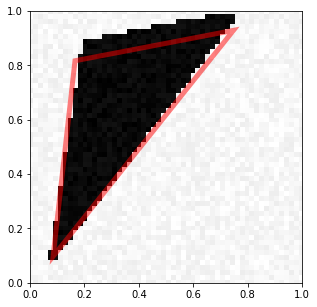

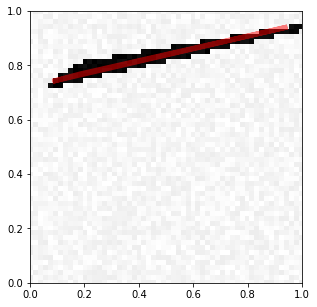

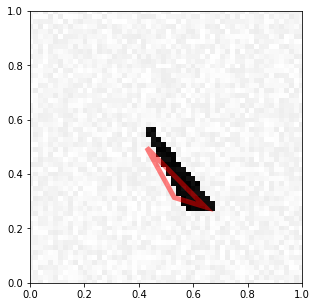

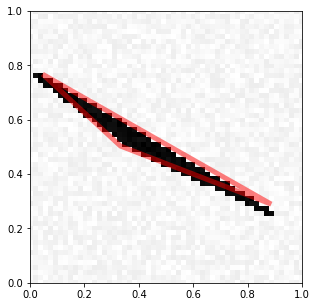

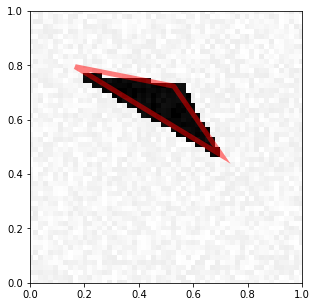

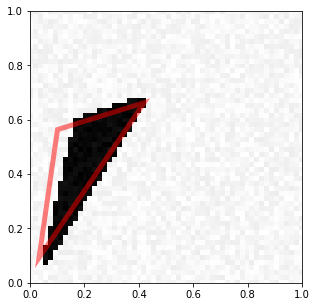

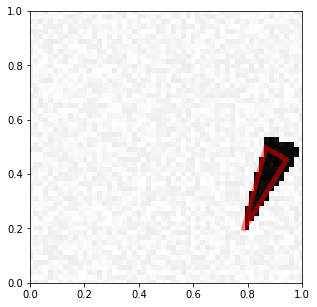

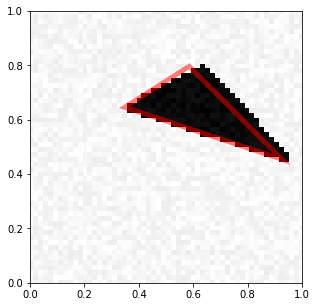

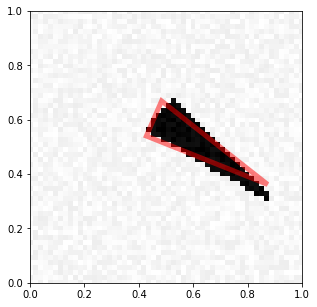

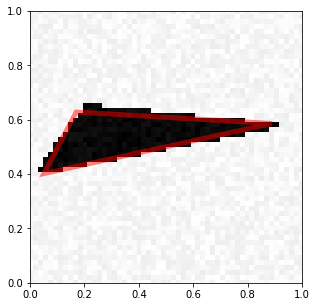

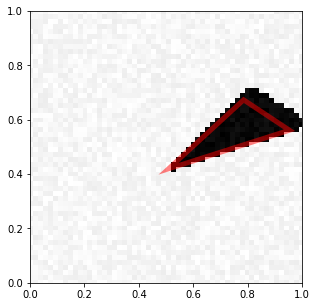

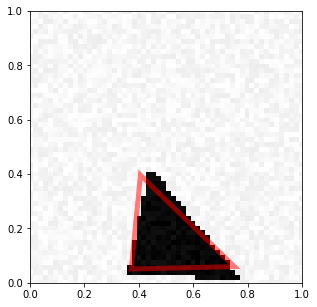

In [93]:
for i in range(40,55):
   
    visualize_prediction(X_test[i], Y_predict_2[i])  

# Image denoising 

Implement a hourglass network for denoising: Modifying the generate_a_* functions to generate pairs of images, where one image has noise with random amplitude, and the second image has the same content but without the noise. Train your network to predict a noise-free image given a noisy
image as input.

I generated a train set with 1000 samples.

In [32]:
[X_train,Y_train] = generate_dataset_denoising(10000, 20,True,verbose=False)

Creating data:


In [0]:
X_train=X_train.reshape(X_train.shape[0],72,72,1)
Y_train=Y_train.reshape(Y_train.shape[0],72,72,1)

I trained different hourglass networks. Here you can see the one that I could train faster and had a good performance. Normally, this kind of architecture is used in image segmentation, but in this case I tried to predict the pixel intensity by doing a regression task. For that reason, I did experiments with both loss functions , "mean_squared_error" and "mean_absolute_error". I preferred the results given by the "mean_squared_error". 

In a normal hourglass architecture, batchnormalization is done after convolutional layers in order to guarantee the stability of the network during the training and it reduces overfitting. Nevetheless, in this particular case, it just made the training process slower and it did not improve the results, so I did not include it. 

The trained hourglas networks use Pooling and Upsampling of dimension 2x2.

In [40]:
mcp = ModelCheckpoint('denoising_model_1.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)


neural_input=Input((72,72,1))

conv1=Conv2D(10,(5,5),activation="relu",padding="same")(neural_input)
#conv1=BatchNormalization()(conv1)
conv1=Conv2D(10,(5,5),activation="relu",padding="same")(conv1)
#conv1=BatchNormalization()(conv1)
pool1=MaxPooling2D(pool_size=(2,2))(conv1)

conv2=Conv2D(20,(5,5),activation="relu",padding="same")(pool1)
#conv2=BatchNormalization()(conv2)
conv2=Conv2D(20,(5,5),activation="relu",padding="same")(conv2)
#conv2=BatchNormalization()(conv2)
pool2=MaxPooling2D(pool_size=(2,2))(conv2)

conv3=Conv2D(40,(5,5),activation="relu",padding="same")(pool2)
#conv3=BatchNormalization()(conv3)
conv3=Conv2D(40,(5,5),activation="relu",padding="same")(conv3)
#conv3=BatchNormalization()(conv3)

up4=UpSampling2D(size=(2,2))(conv3)

up_conv4=Conv2D(20,(5,5),activation="relu",padding="same")(up4)
#up_conv4=BatchNormalization()(up_conv4)
merge4 = concatenate([conv2,up_conv4],axis=3)
conv4=Conv2D(20,(5,5),activation="relu",padding="same")(merge4)
#conv4=BatchNormalization()(conv4)

up5=UpSampling2D(size=(2,2))(conv4)
up_conv5=Conv2D(10,(5,5),activation="relu",padding="same")(up5)
#up_conv5=BatchNormalization()(up_conv5)
merge5 = concatenate([conv1,up_conv5],axis=3)
conv5=Conv2D(10,(5,5),activation="relu",padding="same")(merge5)
#conv5=BatchNormalization()(conv5)

conv6 = Conv2D(1,(1,1),activation="relu")(conv5)
#conv6=BatchNormalization()(conv6)

model_1=Model(inputs=neural_input,outputs=conv6)
model_1.compile(optimizer="adam",loss="mean_squared_error")

model_1.fit(X_train,Y_train,validation_split=0.1,
          batch_size=100,epochs=30,verbose=1,callbacks=[mcp])

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 10s 1ms/step - loss: 0.0964 - val_loss: 0.0043
Epoch 2/30
9000/9000 [==============================] - 7s 800us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 3/30
9000/9000 [==============================] - 7s 801us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/30
9000/9000 [==============================] - 7s 812us/step - loss: 8.9349e-04 - val_loss: 5.8947e-04
Epoch 5/30
9000/9000 [==============================] - 7s 819us/step - loss: 4.9735e-04 - val_loss: 3.8113e-04
Epoch 6/30
9000/9000 [==============================] - 7s 808us/step - loss: 3.2701e-04 - val_loss: 3.1024e-04
Epoch 7/30
9000/9000 [==============================] - 7s 805us/step - loss: 2.5723e-04 - val_loss: 2.2685e-04
Epoch 8/30
9000/9000 [==============================] - 7s 797us/step - loss: 2.1540e-04 - val_loss: 1.8995e-04
Epoch 9/30
9000/9000 [==============================] - 7s 787us/step - loss: 1.8

In [17]:
[X_test, Y_test] = generate_test_set_denoising(verbose=False)

Creating data:


In [0]:
X_test=X_test.reshape(X_test.shape[0],72,72,1)
Y_test=Y_test.reshape(Y_test.shape[0],72,72,1)

This architecture gets  values of 8e-4 of the mean_squared_loss function in the test set and we can see in the fictures how it eliminates noise from the images efficiently. 

In [41]:
model_1.evaluate(X_test,Y_test,verbose=2)

5.7674260266746086e-05

In [0]:
Y_predict_1=model_1.predict(X_test)

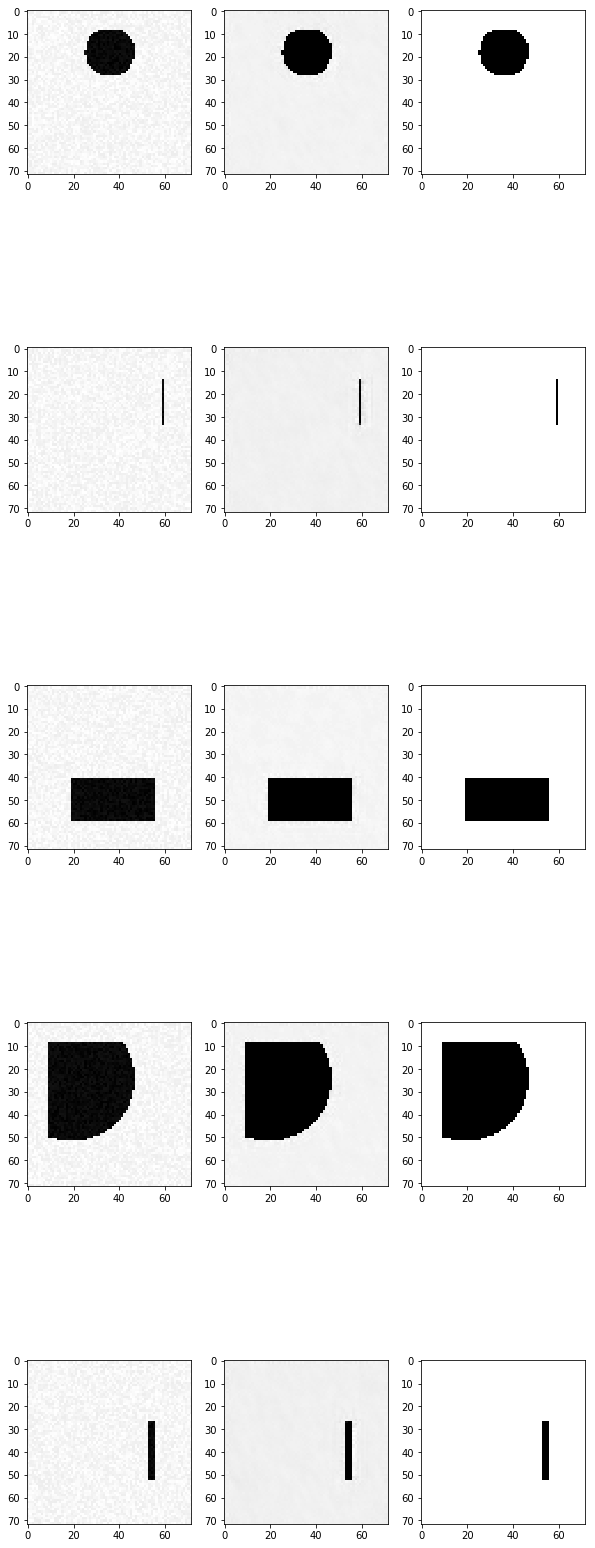

In [43]:
fig=plt.figure(figsize=(10,30))
for i in range(5):
    plt.subplot(5, 3,3*i+1)
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(5, 3,3*i+2)
    plt.imshow(Y_predict_1[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(5, 3,3*i+3)
    plt.imshow(Y_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In a second model, I tried to predict whether the pixel was black of white and I performed image segmentation based on the previous hourglass architecture, without Batchnormalization, but in this case I added an adittional block of convolutional networks with 2 convolutional networks with 80 filters. I also changed the concatenation order. Now, I concatenated each Upsampling with the previous convolutional network of the same dimension.  As the approach changed, the final network returns the probability of being white or black and the loss function is the binary crosss entropy.

In [44]:
mcp = ModelCheckpoint('denoising_model_2.hdf5', monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

neural_input=Input((72,72,1))

conv1=Conv2D(10,(5,5),activation="relu",padding="same")(neural_input)
conv1=Conv2D(10,(5,5),activation="relu",padding="same")(conv1)
pool1=MaxPooling2D(pool_size=(2,2))(conv1)

conv2=Conv2D(20,(5,5),activation="relu",padding="same")(pool1)
conv2=Conv2D(20,(5,5),activation="relu",padding="same")(conv2)
pool2=MaxPooling2D(pool_size=(2,2))(conv2)

conv3=Conv2D(40,(5,5),activation="relu",padding="same")(pool2)
conv3=Conv2D(40,(5,5),activation="relu",padding="same")(conv3)
pool3=MaxPooling2D(pool_size=(2,2))(conv3)

conv4=Conv2D(80,(5,5),activation="relu",padding="same")(pool3)
conv4=Conv2D(80,(5,5),activation="relu",padding="same")(conv4)

up5=UpSampling2D(size=(2,2))(conv4)
merge5 = concatenate([conv3,up5],axis=3)

conv5=Conv2D(40,(5,5),activation="relu",padding="same")(merge5)
conv5=Conv2D(40,(5,5),activation="relu",padding="same")(conv5)

up6=UpSampling2D(size=(2,2))(conv5)
merge6 = concatenate([conv2,up6],axis=3)

conv6=Conv2D(20,(5,5),activation="relu",padding="same")(merge6)
conv6=Conv2D(20,(5,5),activation="relu",padding="same")(conv6)

up7=UpSampling2D(size=(2,2))(conv6)
merge7 = concatenate([conv1,up7],axis=3)

conv7=Conv2D(10,(5,5),activation="relu",padding="same")(merge7)
conv7=Conv2D(10,(5,5),activation="relu",padding="same")(conv7)

conv8 = Conv2D(1,(1,1),activation="sigmoid")(conv7)
model_cross_entropy=Model(inputs=neural_input,outputs=conv8)
model_cross_entropy.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
model_cross_entropy.fit(X_train,Y_train,validation_split=0.1,
          batch_size=100,epochs=30,verbose=2,callbacks=[mcp])

W0806 02:51:43.617743 140297194342272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 12s - loss: 0.1050 - acc: 0.9549 - val_loss: 0.0076 - val_acc: 0.9978
Epoch 2/30
 - 8s - loss: 0.0052 - acc: 0.9984 - val_loss: 0.0031 - val_acc: 0.9991
Epoch 3/30
 - 8s - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0019 - val_acc: 0.9995
Epoch 4/30
 - 8s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0011 - val_acc: 0.9997
Epoch 5/30
 - 8s - loss: 0.0010 - acc: 0.9997 - val_loss: 7.9480e-04 - val_acc: 0.9998
Epoch 6/30
 - 8s - loss: 6.3256e-04 - acc: 0.9998 - val_loss: 5.1053e-04 - val_acc: 0.9999
Epoch 7/30
 - 8s - loss: 4.4355e-04 - acc: 0.9999 - val_loss: 3.4320e-04 - val_acc: 0.9999
Epoch 8/30
 - 8s - loss: 3.1016e-04 - acc: 0.9999 - val_loss: 2.5605e-04 - val_acc: 0.9999
Epoch 9/30
 - 8s - loss: 2.4417e-04 - acc: 0.9999 - val_loss: 1.8792e-04 - val_acc: 1.0000
Epoch 10/30
 - 8s - loss: 1.8058e-04 - acc: 1.0000 - val_loss: 1.5474e-04 - val_acc: 1.0000
Epoch 11/30
 - 8s - loss: 1.3776e-04 - acc: 1.0000 - val_loss: 1.1741e-04 - 

The performance of this architecture is also satisfying, getting an accuracy of  almost  100% in the test set.
As mentioned before, the results show the probability of each pixel of being white of black. In this model, the figures are more friendly to the human eye, as the fond is white. 

In [45]:
model_cross_entropy.evaluate(X_test,Y_test,verbose=2)

[1.1138726586068515e-05, 0.9999967892964681]

In [0]:
Y_predict_2=model_cross_entropy.predict(X_test)

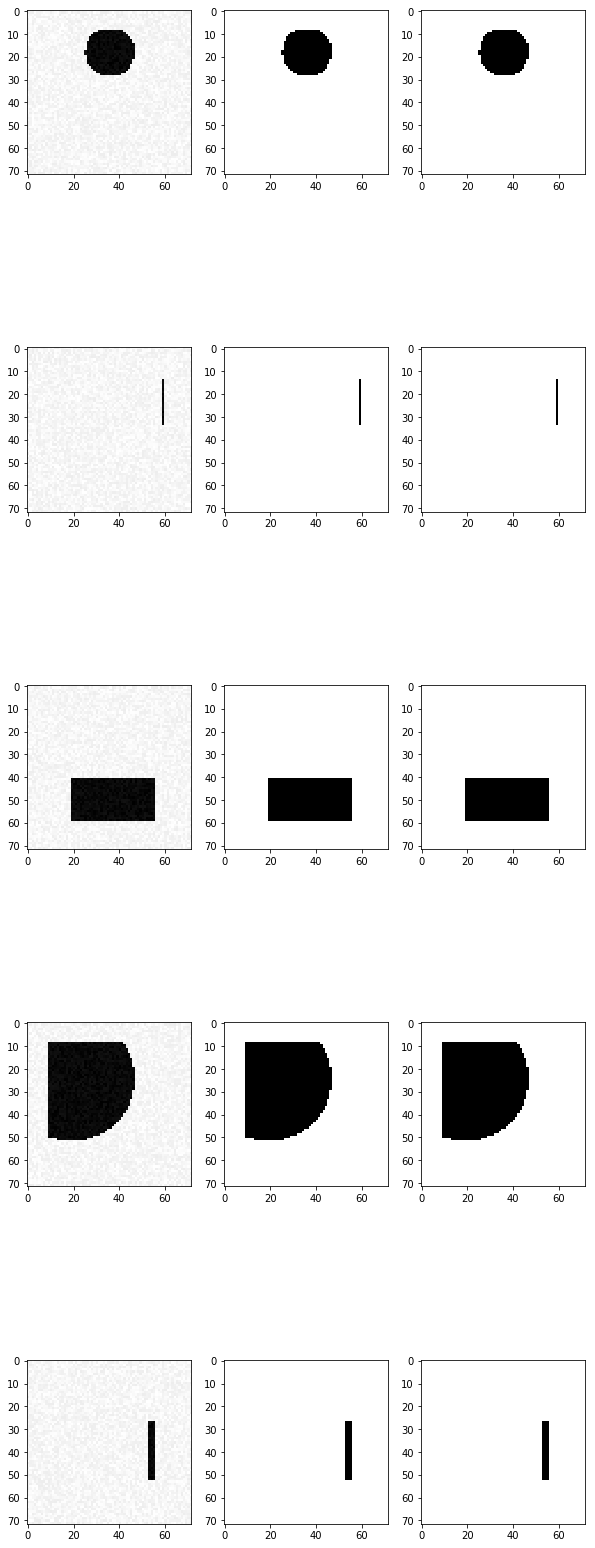

In [47]:
fig=plt.figure(figsize=(10,30))
for i in range(5):
    plt.subplot(5, 3,3*i+1)
    plt.imshow(X_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(5, 3,3*i+2)
    plt.imshow(Y_predict_2[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(5, 3,3*i+3)
    plt.imshow(Y_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
